# Trying to find meaningul features manually

-- strongly related to [fp-feat-engineering.ipynb](fp-feat-engineering.ipynb) --

In case, what is the best similarity metric?


creating data without normalization

In [28]:
from src.data.make_dataset import make_unlabeled, make_labeled

make_labeled("../data/raw/labeled", "../data/interim/labeled", "default")

In [29]:
from scipy.signal import find_peaks
from scipy.stats import entropy
import numpy as np


# I can add number of peaks, 0-crossings, ...
def stat_features(df, col_name):
    # First-order stats
    var = df[col_name].std()
    mean = df[col_name].mean()
    skew = df[col_name].skew()
    kurt = df[col_name].kurtosis()

    # Second-order stats
    signal_entropy = entropy(np.absolute(df[col_name]))

    #Signal related
    n_peaks = len(find_peaks(df[col_name])[0])
    zero_crossings = len(np.where(np.diff(np.sign(df[col_name])))[0])

    return {
        "var": var,
        "mean": mean,
        "skew": skew,
        "kurt": kurt,
        "entropy": signal_entropy,
        "n-peaks": n_peaks,
        "zero-cross": zero_crossings,
    }

In [31]:
from src.features.utils import save_feat_files
from progress.bar import ShadyBar
import pandas as pd
import os


def extract_features(input_filepath: str, output_filepath: str) -> pd.DataFrame:
    """
    Builds features for clustering.
    """
    file_list = glob.glob(input_filepath + '/*')
    features_set = np.ndarray(shape=(len(file_list), 7))
    with ShadyBar(f"Extracting features {input_filepath}...", max=len(file_list)) as bar:
        for i, f in enumerate(file_list):
            interim_data = np.loadtxt(f, delimiter=',', skiprows=1)

            y_axis_data = interim_data[:, 1]

            features_set[i, :] = list(stat_features(pd.DataFrame({"data": y_axis_data}), col_name="data").values())

            bar.next()

    save_feat_files(features_set, os.path.join(output_filepath, "peaks_features.csv"))


extract_features("../data/interim/labeled", "../data/processed/labeled")

In [32]:
import pickle
import glob

file_list = glob.glob('{0}/*'.format("../data/processed//labeled"))

for f in file_list:
    with open(f, "rb") as f:
        data_x = pickle.load(f)

data_x = data_x.reshape(61, -1)

/Users/paissanfrancesco/PycharmProjects/raman_spectrogram_analysis/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/paissanfrancesco/PycharmProjects/raman_spectrogram_analysis/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/paissanfrancesco/PycharmProjects/raman_spectrogram_analysis/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated fun

<AxesSubplot:ylabel='Density'>

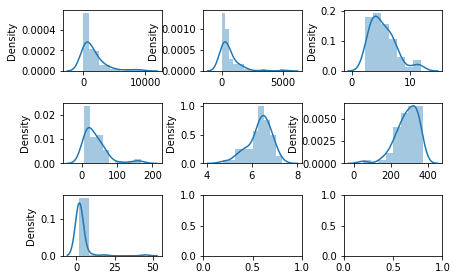

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 3)
fig.tight_layout()

sns.distplot(data_x[:, 0], kde=True, ax=axes[0, 0])
sns.distplot(data_x[:, 1], kde=True, ax=axes[0, 1])
sns.distplot(data_x[:, 2], kde=True, ax=axes[0, 2])
sns.distplot(data_x[:, 3], kde=True, ax=axes[1, 0])
sns.distplot(data_x[:, 4], kde=True, ax=axes[1, 1])
sns.distplot(data_x[:, 5], kde=True, ax=axes[1, 2])
sns.distplot(data_x[:, 6], kde=True, ax=axes[2, 0])

In [35]:
from scipy.stats import zscore

normed_features = np.ndarray(shape=data_x.shape)

for i in range(7):
    normed_features[:, i] = zscore(data_x[:, i])

/Users/paissanfrancesco/PycharmProjects/raman_spectrogram_analysis/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/paissanfrancesco/PycharmProjects/raman_spectrogram_analysis/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/paissanfrancesco/PycharmProjects/raman_spectrogram_analysis/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated fun

<AxesSubplot:ylabel='Density'>

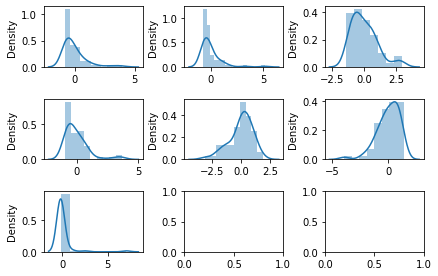

In [36]:
fig, axes = plt.subplots(3, 3)
fig.tight_layout()

sns.distplot(normed_features[:, 0], kde=True, ax=axes[0, 0])
sns.distplot(normed_features[:, 1], kde=True, ax=axes[0, 1])
sns.distplot(normed_features[:, 2], kde=True, ax=axes[0, 2])
sns.distplot(normed_features[:, 3], kde=True, ax=axes[1, 0])
sns.distplot(normed_features[:, 4], kde=True, ax=axes[1, 1])
sns.distplot(normed_features[:, 5], kde=True, ax=axes[1, 2])
sns.distplot(normed_features[:, 6], kde=True, ax=axes[2, 0])

In [55]:
from sklearn_extra.cluster import KMedoids


def benchmark_kmed(data: np.ndarray, metric: callable) -> list:
    inertia = []
    for i in range(3, 61):
        model = KMedoids(n_clusters=i, metric=metric).fit(data)
        inertia.append(model.inertia_)

    return inertia

In [77]:
def plot_bench_results(metric):
    k_med_raw = benchmark_kmed(data_x, metric = metric)
    k_med_norm = benchmark_kmed(normed_features, metric = metric)

    # plt.scatter(list(range(3, 61)), k_med_raw, label='raw')
    plt.scatter(list(range(3, 61)), k_med_norm, label='norm')

    plt.legend()

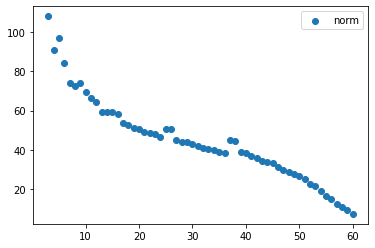

In [78]:
plot_bench_results(lambda x,y: np.linalg.norm(x-y))

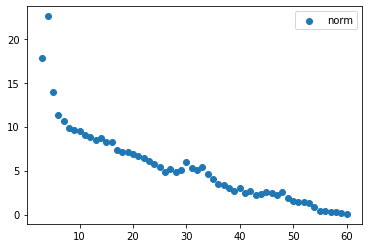

In [79]:
from scipy.spatial.distance import cosine, correlation

plot_bench_results(lambda x, y: cosine(x, y))

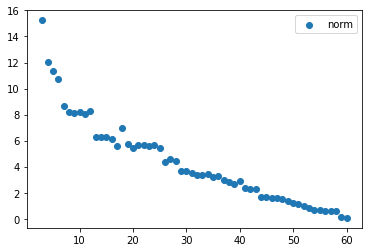

In [80]:
plot_bench_results(lambda x, y: correlation(x, y))

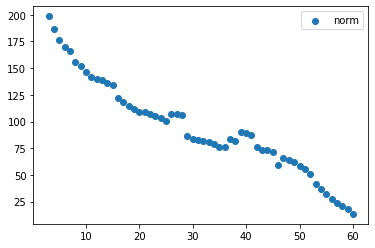

In [83]:
plot_bench_results(lambda x,y: np.linalg.norm(x-y, ord=1))